# In this notebook:

## a realistic dataset: predicting academic performance
- we use Pandas dataframes to handle the training set

## - multi-class problem

## - > 2 features

## - Overfitting

## - Cross-validation

## - Ensemble methods to mitigate overfitting in decision trees: Random Forests

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import (
    LinearSVC,
    SVC,
)
from sklearn.tree import DecisionTreeClassifier

In [4]:
path = 'https://raw.githubusercontent.com/PaoloMissier/DataScience-class-demos/master/DATA/'
df = pd.read_csv(path + 'Academic/academic_performance_clean.csv', header=0)
pred_feat = 'Class'
seed = 10

## the dataset has the following attributes:

In [ ]:
df.columns

Index(['Gender', 'Nationality', 'StageID', 'GradeID', 'SectionID', 'Topic',
       'Semester', 'Relation', 'RaisedHands', 'VisitedResources',
       'AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey',
       'ParentSchoolSatisfaction', 'StudentAbsenceDays', 'Class'],
      dtype='object')

 ## Some attributes are numerical, others are categorical, as follows.

In [ ]:
categorical = ['Gender', 'Nationality', 'StageID', 'GradeID', 'SectionID',
               'Topic','Semester', 'Relation', 'ParentAnsweringSurvey',
               'ParentSchoolSatisfaction', 'StudentAbsenceDays']

numerical = ['RaisedHands', 'VisitedResources',
             'AnnouncementsView', 'Discussion']

Here are the codes for the categorical attributes:

In [ ]:
for v in categorical:
    print(f"{v}: {df[v].unique()}")

Gender: ['Male' 'Female']
Nationality: ['Kuwait' 'Lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'Venezuela'
 'Iran' 'Tunisia' 'Morocco' 'Syria' 'Palestine' 'Iraq' 'Libya']
StageID: ['LowerLevel' 'MiddleSchool' 'HighSchool']
GradeID: ['G-04' 'G-07' 'G-08' 'G-06' 'G-05' 'G-09' 'G-12' 'G-11' 'G-10' 'G-02']
SectionID: ['section_A' 'section_B' 'section_C']
Topic: ['IT' 'Math' 'Arabic' 'Science' 'English' 'Quran' 'Spanish' 'French'
 'History' 'Biology' 'Chemistry' 'Geology']
Semester: ['First' 'Second']
Relation: ['Father' 'Mother']
ParentAnsweringSurvey: ['Yes' 'No']
ParentSchoolSatisfaction: ['Good' 'Bad']
StudentAbsenceDays: ['Under-7' 'Above-7']


## we have one distinguished variable, `Class`, which is the category we will want to predict given all other variables

## for categorical variables, we can plot the counts of each value:

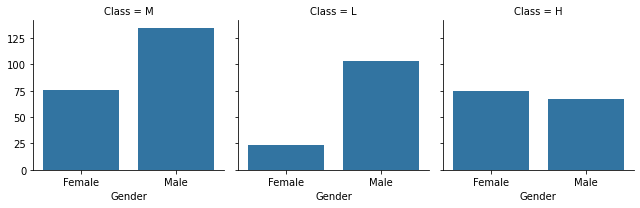

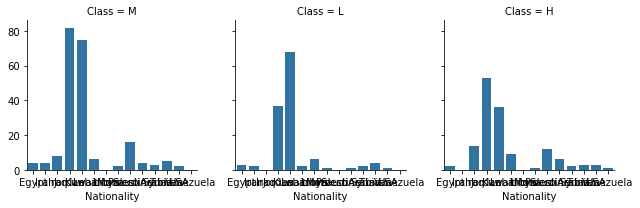

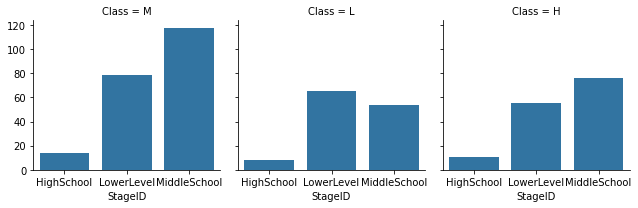

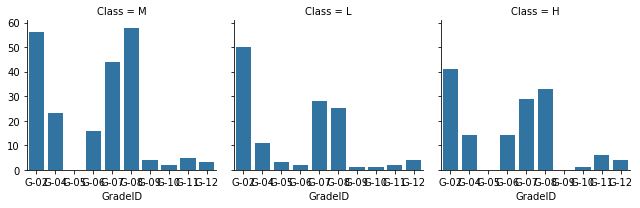

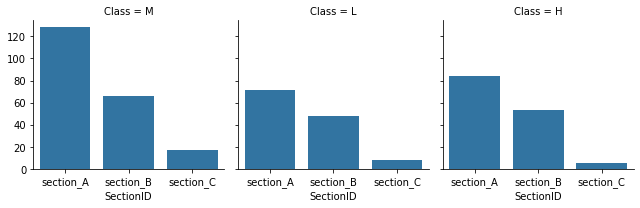

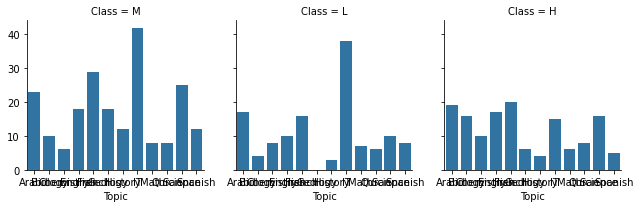

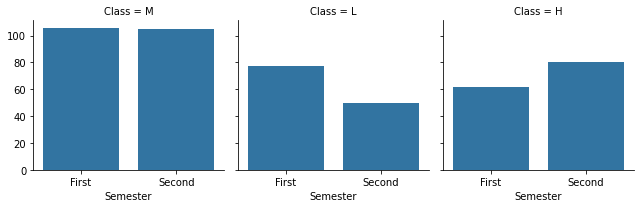

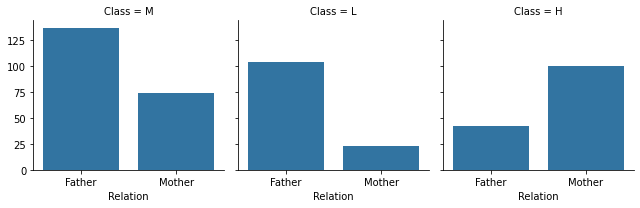

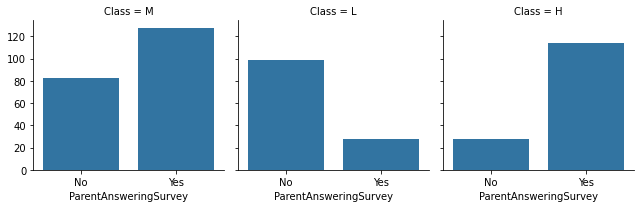

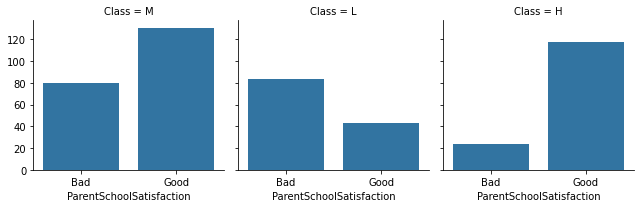

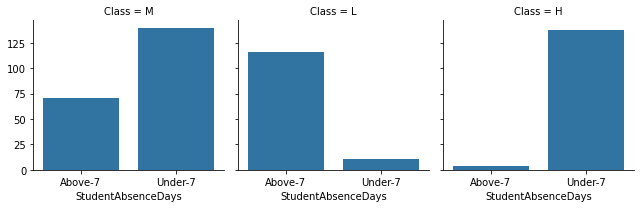

In [ ]:
for v in categorical:
    g = sns.FacetGrid(df, col="Class")
    g.map(sns.countplot, v, order=sorted(df[v].unique()))

### Some of these deserve better plots:

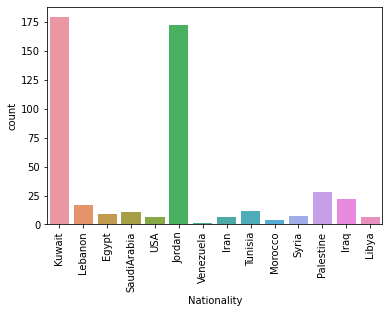

In [ ]:
g = sns.countplot(x="Nationality", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

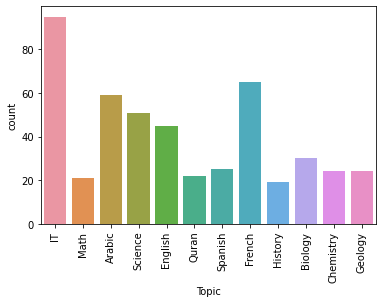

In [ ]:
g = sns.countplot(x="Topic", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

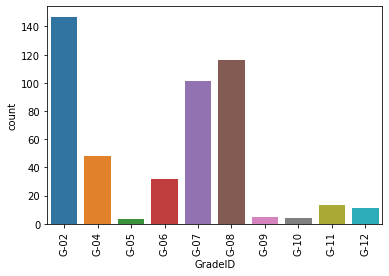

In [ ]:
g = sns.countplot(x="GradeID", data=df, order=sorted(df['GradeID'].unique()))
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

## summary statistics for numerical variables:

In [ ]:
df[numerical].describe()

,RaisedHands,VisitedResources,AnnouncementsView,Discussion
count,480.000000,480.000000,480.000000,480.000000
mean,46.775000,54.797917,37.918750,43.283333
std,30.779223,33.080007,26.611244,27.637735
min,0.000000,0.000000,0.000000,1.000000
25%,15.750000,20.000000,14.000000,20.000000
50%,50.000000,65.000000,33.000000,39.000000
75%,75.000000,84.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


## for numerical variables, we can plot their distribution across the dataset:

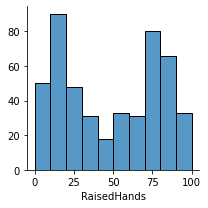

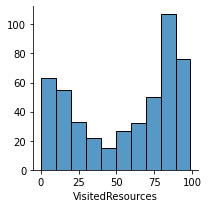

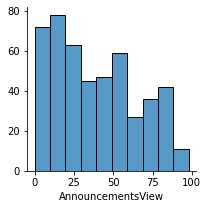

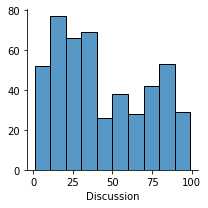

In [ ]:
for v in numerical:
    g = sns.FacetGrid(df)
    g.map(sns.histplot, v)

## it is also interesting to look at the distributions of numerical variables across the two Class outcomes, possibly further aggregated, eg by Gender:

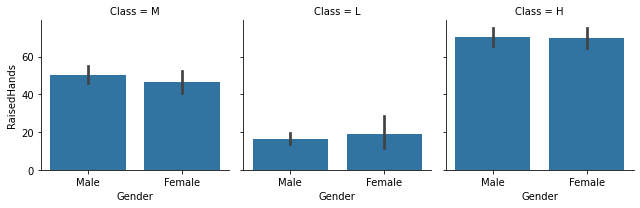

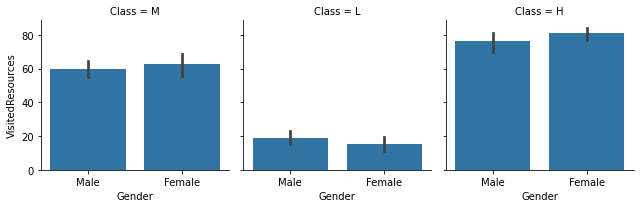

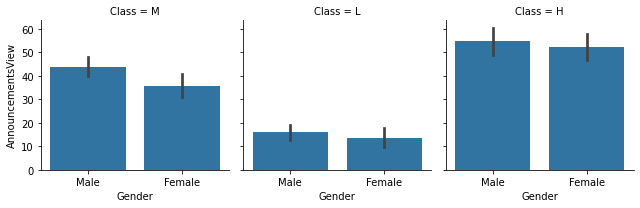

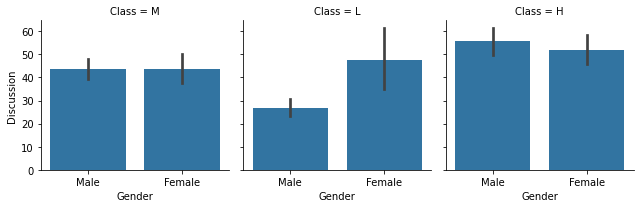

In [ ]:
for v in numerical:
    g = sns.FacetGrid(df, col="Class")
    g.map(sns.barplot, "Gender", v, order=["Male", "Female"])

## we can also easily switch the type of plots to achieve different visualisations:

hint: try replacing the `kind` with one of `box`, `boxen`, `violin`, `point`, `bar`, `swarm`

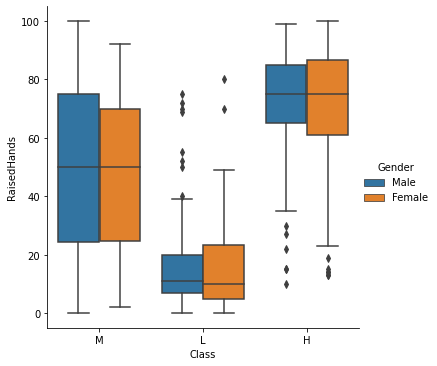

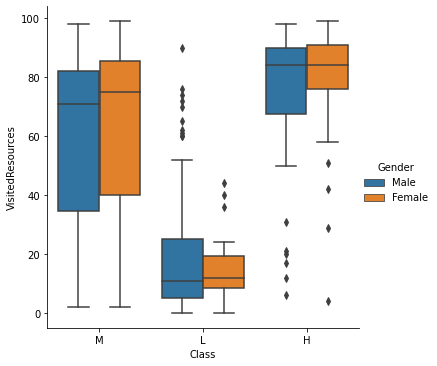

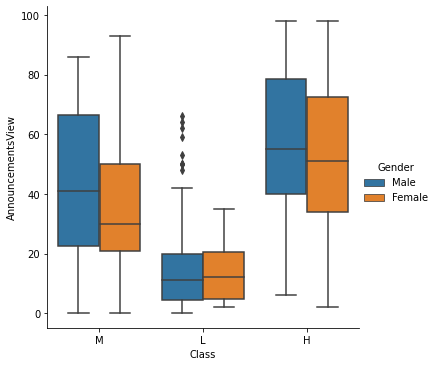

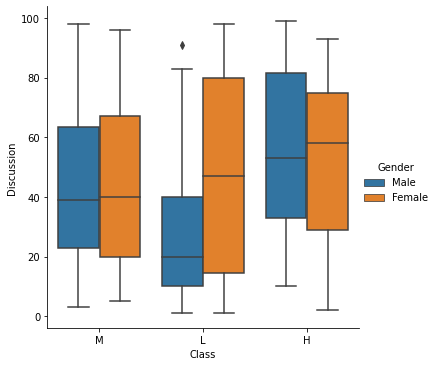

In [ ]:
for v in numerical:
    g = sns.catplot(x="Class", y=v, data=df, kind="box", hue='Gender')

# one-hot encoding 
### classifiers require that categorical variables be encoded in a specific way.

we are going to create *dummy variables* for each of these variables. 
we can either:

- assign a numeric value to each categorical value in a set, eg GradeID
- generates one new column for each value of a variable, see eg Nationality

In [ ]:
col = ["Nationality", "SectionID", "Topic"]

for c in col:
    dummies = []
    dummies.append(pd.get_dummies(df[c]))
    df_dummies = pd.concat(dummies, axis=1)
    df = pd.concat((df, df_dummies), axis=1)
    df = df.drop([c], axis=1)



- Gender: 0 Female, 1 Male
- StageID: 0 Lower, 1 Middle, 2 High
- GradeID: 0 - 11
- Semester: 0 First, 1 Second
- Relation: 0 Mother, 1 Father
- ParentAnswering: 0 No, 1 Yes
- ParentSchool: 0 Bad, 1 Good
- Class: 0 L, 1 M, 2 H
- Topic: 
- StudentAbsence: 0 Under-7, 1 Above-7
- Nationality:  

here is the result:

In [ ]:
## reload the dataset ready for processing
path = 'https://raw.githubusercontent.com/Trotts/csc2034-ds-demos/master/DATA/'
df = pd.read_csv(path + 'Academic/academic_onehot.csv', header=0)
df.shape

(480, 42)

In [ ]:
df.columns

Index(['Gender', 'StageID', 'GradeID', 'Semester', 'Relation', 'RaisedHands',
       'VisitedResources', 'AnnouncementsView', 'Discussion',
       'ParentAnsweringSurvey', 'ParentSchoolSatisfaction',
       'StudentAbsenceDays', 'Class', 'Egypt', 'Iran', 'Iraq', 'Jordan',
       'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Palestine', 'SaudiArabia',
       'Syria', 'Tunisia', 'USA', 'Venezuela', 'section_A', 'section_B',
       'section_C', 'Arabic', 'Biology', 'Chemistry', 'English', 'French',
       'Geology', 'History', 'IT', 'Math', 'Quran', 'Science', 'Spanish'],
      dtype='object')

In [ ]:
df.head()

,Gender,StageID,GradeID,Semester,Relation,RaisedHands,VisitedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,...,Chemistry,English,French,Geology,History,IT,Math,Quran,Science,Spanish
0,1,0,3,0,1,15,16,2,20,1,...,0,0,0,0,0,1,0,0,0,0
1,1,0,3,0,1,20,20,3,25,1,...,0,0,0,0,0,1,0,0,0,0
2,1,0,3,0,1,10,7,0,30,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,3,0,1,30,25,5,35,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,3,0,1,40,50,12,50,0,...,0,0,0,0,0,1,0,0,0,0


### values for each of the variables:

In [ ]:
newCategorical = [col for col in df.columns if col not in numerical]

for v in newCategorical:
    print(f"{v}: {df[v].unique()}")

Gender: [1 0]
StageID: [0 1 2]
GradeID: [ 3  6  7  5  4  8 11 10  9  1]
Semester: [0 1]
Relation: [1 0]
ParentAnsweringSurvey: [1 0]
ParentSchoolSatisfaction: [1 0]
StudentAbsenceDays: [0 1]
Class: [1 0 2]
Egypt: [0 1]
Iran: [0 1]
Iraq: [0 1]
Jordan: [0 1]
Kuwait: [1 0]
Lebanon: [0 1]
Libya: [0 1]
Morocco: [0 1]
Palestine: [0 1]
SaudiArabia: [0 1]
Syria: [0 1]
Tunisia: [0 1]
USA: [0 1]
Venezuela: [0 1]
section_A: [1 0]
section_B: [0 1]
section_C: [0 1]
Arabic: [0 1]
Biology: [0 1]
Chemistry: [0 1]
English: [0 1]
French: [0 1]
Geology: [0 1]
History: [0 1]
IT: [1 0]
Math: [0 1]
Quran: [0 1]
Science: [0 1]
Spanish: [0 1]


## we now check that the class values are not *unbalanced*:

In [ ]:
df[pred_feat].value_counts()

#  0 L, 1 M, 2 H

1    211
2    142
0    127
Name: Class, dtype: int64

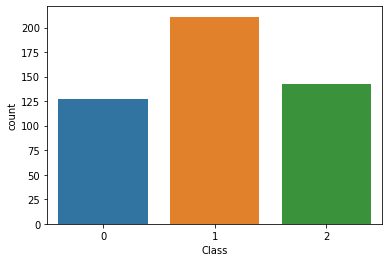

In [ ]:
g = sns.countplot(x="Class", data=df)

Class = 1 (Medium) twice the size of each of the other two... let us rebalance.

since we have few data points, we amplify the minority classes using SMOTE

In [ ]:
# Unbalanced train set
X = df.drop([pred_feat], axis=1).values
CL = df[pred_feat].values

In [ ]:
# rebalance through upsampling
X_reb, CL_reb = SMOTE().fit_resample(X, CL)

print(f"Unbalanced Counts:\n{Counter(CL)}\n")
print(f"Balanced Counts:\n{Counter(CL_reb)}")

Unbalanced Counts:
Counter({1: 211, 2: 142, 0: 127})

Balanced Counts:
Counter({1: 211, 0: 211, 2: 211})


In [ ]:
# Split data in train / tet
XTrain, XTest, CLTrain, CLTest = train_test_split(X_reb, CL_reb, test_size = 0.33, random_state=seed)

In [ ]:
print(f"Training Set Counts:\n{Counter(CLTrain)}\n")
print(f"Test Set Counts:\n{Counter(CLTest)}")

Training Set Counts:
Counter({2: 152, 1: 143, 0: 129})

Test Set Counts:
Counter({0: 82, 1: 68, 2: 59})


In [ ]:
## scaling
scaler = StandardScaler()
XTrain, XTest  = (scaler.fit_transform(d)
                  for d in (XTrain, XTest))

### first attempt at modelling: linear model using _logistic regression_

In [ ]:
clf = LogisticRegression(penalty='l2', C=1, solver='lbfgs',multi_class='auto', max_iter=10000)
clf.fit(XTrain, CLTrain)

# predictions on training set
CL_pred_Train = clf.predict(XTrain)

# predictions on test set
CL_pred_Test = clf.predict(XTest)

print('Train Set Predictions Report:\n')
print(classification_report(CLTrain, CL_pred_Train))
print('Test Set Predictions Report:\n')
print(classification_report(CLTest, CL_pred_Test))

scores = cross_val_score(clf, XTrain, CLTrain, cv=3)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       129
           1       0.81      0.79      0.80       143
           2       0.87      0.89      0.88       152

    accuracy                           0.87       424
   macro avg       0.87      0.87      0.87       424
weighted avg       0.87      0.87      0.87       424

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        82
           1       0.66      0.71      0.68        68
           2       0.72      0.85      0.78        59

    accuracy                           0.78       209
   macro avg       0.78      0.78      0.78       209
weighted avg       0.80      0.78      0.78       209

Cross-validation scores: 0.76 (± 0.01)


## Hyper-parameter tuning


note that logit has one hyper-parameter: `C`

can we improve on performance by tuning this _hyper-parameter_?

how do we select the /optimal/ values for these hyper-parameters?

*note*: the code below is from the scikit doc on [Parameter estimation using grid search with cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [1, 10, 100]}]

clf = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000), tuned_parameters, cv=5)
clf.fit(XTrain, CLTrain)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.776 (± 0.073) for {'C': 1}
0.776 (± 0.070) for {'C': 10}
0.774 (± 0.068) for {'C': 100}


### Second attempt: SVM linear  (Support Vector Machines)

In [ ]:
svm = LinearSVC(C=1, max_iter=10000)
clf = svm.fit(XTrain, CLTrain)

# predictions on training set
CL_pred_Train = clf.predict(XTrain)

# predictions on test set
CL_pred_Test = clf.predict(XTest)
    
print('Train Set Predictions Report:\n')
print(classification_report(CLTrain, CL_pred_Train))
print('Test Set Predictions Report:\n')
print(classification_report(CLTest, CL_pred_Test))

scores = cross_val_score(clf, XTrain, CLTrain, cv=3)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       129
           1       0.83      0.75      0.79       143
           2       0.86      0.90      0.88       152

    accuracy                           0.86       424
   macro avg       0.86      0.86      0.86       424
weighted avg       0.86      0.86      0.86       424

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.94      0.82      0.88        82
           1       0.60      0.59      0.59        68
           2       0.65      0.78      0.71        59

    accuracy                           0.73       209
   macro avg       0.73      0.73      0.73       209
weighted avg       0.75      0.73      0.74       209

Cross-validation scores: 0.74 (± 0.08)


### Let's try a non-linear classifier: SVM with polynomial kernel

In [ ]:
clf = SVC(kernel='poly')
clf.fit(XTrain, CLTrain)

CL_pred_Train = clf.predict(XTrain)
CL_pred_Test = clf.predict(XTest)

print('Train Set Predictions Report:\n')
print(classification_report(CLTrain, CL_pred_Train))
print('Test Set Predictions Report:\n')
print(classification_report(CLTest, CL_pred_Test))

scores = cross_val_score(clf, XTrain, CLTrain, cv=3)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       129
           1       0.90      0.69      0.78       143
           2       0.82      0.95      0.88       152

    accuracy                           0.87       424
   macro avg       0.87      0.87      0.87       424
weighted avg       0.87      0.87      0.86       424

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.59      0.44      0.50        68
           2       0.57      0.81      0.67        59

    accuracy                           0.69       209
   macro avg       0.69      0.69      0.68       209
weighted avg       0.71      0.69      0.69       209

Cross-validation scores: 0.72 (± 0.06)


## SVM with RBF kernel

In [ ]:
clf = SVC(kernel='rbf')
clf.fit(XTrain, CLTrain)

CL_pred_Train = clf.predict(XTrain)
CL_pred_Test = clf.predict(XTest)

print('Train Set Predictions Report:\n')
print(classification_report(CLTrain, CL_pred_Train))
print('Test Set Predictions Report:\n')
print(classification_report(CLTest, CL_pred_Test))

scores = cross_val_score(clf, XTrain, CLTrain, cv=3)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       129
           1       0.88      0.83      0.86       143
           2       0.90      0.92      0.91       152

    accuracy                           0.91       424
   macro avg       0.91      0.91      0.91       424
weighted avg       0.90      0.91      0.90       424

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.94      0.78      0.85        82
           1       0.58      0.66      0.62        68
           2       0.68      0.73      0.70        59

    accuracy                           0.73       209
   macro avg       0.73      0.72      0.72       209
weighted avg       0.75      0.73      0.73       209

Cross-validation scores: 0.73 (± 0.06)


## Tune the hyper-parameters by cross-validation

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5)
clf.fit(XTrain, CLTrain)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.731 (± 0.118) for {'C': 1, 'kernel': 'rbf'}
0.755 (± 0.071) for {'C': 10, 'kernel': 'rbf'}
0.743 (± 0.028) for {'C': 100, 'kernel': 'rbf'}
0.719 (± 0.049) for {'C': 1, 'kernel': 'poly'}
0.755 (± 0.036) for {'C': 10, 'kernel': 'poly'}
0.750 (± 0.017) for {'C': 100, 'kernel': 'poly'}
0.764 (± 0.032) for {'C': 1, 'kernel': 'linear'}
0.764 (± 0.052) for {'C': 10, 'kernel': 'linear'}
0.764 (± 0.060) for {'C': 100, 'kernel': 'linear'}


## decision trees are attractive but may overfit the data

In [ ]:
clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(XTrain, CLTrain)

# predictions
CL_pred_Train = clf.predict(XTrain)
CL_pred_Test = clf.predict(XTest)

print('Train Set Predictions Report\n')
print(classification_report(CLTrain, CL_pred_Train))
print('Test Set Predictions Report\n')
print(classification_report(CLTest, CL_pred_Test))

scores = cross_val_score(clf, XTrain, CLTrain, cv=3)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       129
           1       0.99      0.97      0.98       143
           2       0.97      0.99      0.98       152

    accuracy                           0.98       424
   macro avg       0.98      0.98      0.98       424
weighted avg       0.98      0.98      0.98       424

Test Set Predictions Report

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        82
           1       0.69      0.65      0.67        68
           2       0.69      0.85      0.76        59

    accuracy                           0.78       209
   macro avg       0.78      0.78      0.77       209
weighted avg       0.79      0.78      0.78       209

Cross-validation scores: 0.72 (± 0.06)


## to mitigate overfitting, we introduce _ensemble models_: Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=10, max_depth=50, random_state=seed)
clf.fit(XTrain, CLTrain)

# predictions
CL_pred_Train = clf.predict(XTrain)
CL_pred_Test = clf.predict(XTest)

print('Train Set Predictions Report:\n')
print(classification_report(CLTrain, CL_pred_Train))
print('Test Set Predictions Report:\n')
print(classification_report(CLTest, CL_pred_Test))

scores = cross_val_score(clf, XTrain, CLTrain, cv=3)
print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       0.99      1.00      1.00       143
           2       1.00      0.99      1.00       152

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.91        82
           1       0.73      0.69      0.71        68
           2       0.77      0.83      0.80        59

    accuracy                           0.81       209
   macro avg       0.80      0.81      0.81       209
weighted avg       0.81      0.81      0.81       209

Cross-validation scores: 0.80 (± 0.01)


## let us tune the hyper-parameters `max_depth` and  `n_estimators`

ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

A search consists of:

- an estimator (regressor or classifier such as sklearn.svm.SVC());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

In [ ]:
# scores = ['precision', 'recall']

tuned_parameters = [{'n_estimators': [10,50,100,200],
                     'max_depth': [5,10,20,50]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
clf.fit(XTrain, CLTrain)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:.3f} (± {std * 2:.03f}) for {params}\n")

Best parameters set found on development set:

{'max_depth': 50, 'n_estimators': 200}

Grid scores on development set:

0.764 (± 0.082) for {'max_depth': 5, 'n_estimators': 10}

0.800 (± 0.064) for {'max_depth': 5, 'n_estimators': 50}

0.802 (± 0.082) for {'max_depth': 5, 'n_estimators': 100}

0.809 (± 0.069) for {'max_depth': 5, 'n_estimators': 200}

0.778 (± 0.092) for {'max_depth': 10, 'n_estimators': 10}

0.812 (± 0.085) for {'max_depth': 10, 'n_estimators': 50}

0.830 (± 0.050) for {'max_depth': 10, 'n_estimators': 100}

0.819 (± 0.076) for {'max_depth': 10, 'n_estimators': 200}

0.797 (± 0.064) for {'max_depth': 20, 'n_estimators': 10}

0.816 (± 0.076) for {'max_depth': 20, 'n_estimators': 50}

0.823 (± 0.042) for {'max_depth': 20, 'n_estimators': 100}

0.819 (± 0.074) for {'max_depth': 20, 'n_estimators': 200}

0.785 (± 0.073) for {'max_depth': 50, 'n_estimators': 10}

0.821 (± 0.077) for {'max_depth': 50, 'n_estimators': 50}

0.821 (± 0.061) for {'max_depth': 50, 'n_estimators'